# Zacros kMC for O-Pt(111)

In [1]:
import numpy as np
from pathlib import Path
import subprocess, os
import matplotlib.pyplot as plt
import scm.pyzacros as pz
import zacros_functions as zf


In [2]:
# Path to Zacros executables
zacros_path = Path("/home/akandra/zacros/zacros_4.0/build_intel")
zacros3_path = Path("/home/akandra/zacros/zacros_3.03/build_std")

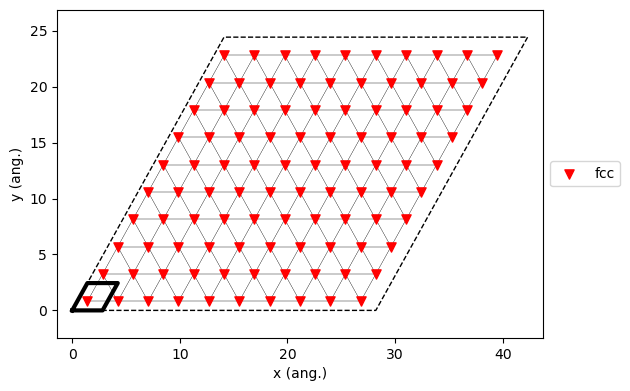

In [2]:
# Setting up a system and running Zacros simulations

# lattice setup
lattice_constant = 2.821135  # in Angstroms 
# lattice vectors for Pt(111)
unit_cell = lattice_constant*np.array([ 
                                [1.0,         0.0],
                                [0.5, np.sqrt(3)/2] ])
lat_size = "40x40"

# Zacros run directory
run_dir = "zacros_run"

# Adsorbates
ads_name = 'O*'

# Cluster definition
def clusters(n):

  # 2-body clusters up to 9nn for Pt(111) from Florian's DFT calculations
  cluster_list_all =  [0,     1,     2,      3,     4,     5,     6,     7,     8,    9]
  eng_list_all =    [0.0, 0.123, 0.029, -0.010, 0.023, 0.023, 0.015, 0.016, 0.030, 0.014]

  cluster_list = cluster_list_all[:n+1]
  eng_list = eng_list_all[:n+1]
  cl_dir = f'upto{n}nn'

  return cluster_list, eng_list, cl_dir

# Get lattice size from lat_size string
Nx_lat, Ny_lat = [int(y) for y in lat_size.split('x')]

# Visualize lattice using pyzacros
lattice = pz.Lattice(cell_vectors=unit_cell,
                        repeat_cell=[10,10],
                         site_types=["fcc"],
                   site_coordinates=[(0.333333333333333,0.333333333333333)],
                   neighboring_structure=[ [(0,0), pz.Lattice.NORTH],
                                           [(0,0), pz.Lattice.EAST],
                                           [(0,0), pz.Lattice.SOUTHEAST] ] )
lattice.plot()

In [61]:
# Loop over different coverages
temperature = 200  # in Kelvin
cluster_list, eng_list, cl_dir = clusters(0)

for coverage in [0.08]:

    wdir = Path(f"{run_dir}_{int(round(1000*coverage)):04d}_{cl_dir}_{temperature:04d}")
    try:
        wdir.mkdir(exist_ok=False)
    except FileExistsError:
        print(f"Directory {wdir} already exists. Skipping...")
        continue

    # Number of adsorbates
    N_ads = int(coverage * Nx_lat * Ny_lat)

    # Setup Zacros input 
    header = "Pt(111)"+lat_size
    zf.make_lattice_input(wdir, 1, 1, unit_cell, Nx_lat, Ny_lat, header=header)
    zf.make_mechanism_input(wdir, header=header)
    zf.make_energetics_input(wdir, cluster_list, eng_list)
    zf.make_state_input(wdir, [(ads_name,N_ads)], header=header)
    zf.make_simulation_input(wdir, temperature=temperature, max_steps=50000, snapshots='on event 500', wall_time=3600,   header=header)

    # Change to Zacros run directory
    original_dir = os.getcwd()
    os.chdir(wdir)

    try:
        # Run zacros.x
        result = subprocess.run([str(zacros_path / "zacros.x")], 
                            check=True,
                            capture_output=True,
                            text=True)
        print(result.stdout)
        
    except subprocess.CalledProcessError as e:
        print("Error running zacros.x:")
        print(e.stderr)
        
    finally:
        # Change back to original directory
        os.chdir(original_dir)
        


 Logger initialised at level INFO
 NO THREADS



In [8]:
def get_lattice_xy(lattice_input_file):
    """
    Produces cartesian coordinates of lattice sites 
    Parameters
    ----------
    lattice_input_file : str or Path
        Path to the Zacros lattice input file.
    Returns
    -------
    coords : np.array
        (List of) Array(s) of cartesian coordinates of lattice sites.
    """

    # Read lattice input file

    try:
        with open(lattice_input_file, 'r') as f:
            content = [line for line in f.readlines() if (line.strip() and not line.startswith('#'))]
    except FileNotFoundError:
        raise FileNotFoundError(f"Lattice input file '{lattice_input_file}' not found.")
    finally:
        content = [line.split('#')[0] for line in content]

    for i,line in enumerate(content):
            if 'cell_vectors' in line:
                unit_cell = np.array([ [float(x) for x in content[i+1].split()],
                              [float(x) for x in content[i+2].split()] ])
            if 'repeat_cell' in line:
                repeat_cell = np.array([ int(x) for x in line.split()[1:3] ])
            if 'n_site_types' in line:
                n_site_types = int(line.split()[1])
            if 'n_cell_sites' in line:
                n_cell_sites = int(line.split()[1])
            if 'site_types' in line:
                site_types_names = line.split()[1:]
            if 'site_coordinates' in line:
                site_coordinates = []
                for j in range(n_cell_sites):
                    site_coordinates.append([float(x) for x in content[i+1+j].split()[:2]])
                site_uc_coordinates = np.array(site_coordinates) @ unit_cell


    site_coordinates = []
    site_types = []
    for i in range(repeat_cell[0]):
        for j in range(repeat_cell[1]):
            shift = np.array([i,j]) @ unit_cell
            for coords,st in zip(site_uc_coordinates , site_types_names):
                site_types.append(st)
                site_coordinates.append(coords + shift)
                site_types.append(st)

    v1 = repeat_cell[0] * unit_cell[0]
    v2 = repeat_cell[1] * unit_cell[1]

    return np.array(site_coordinates),v1,v2



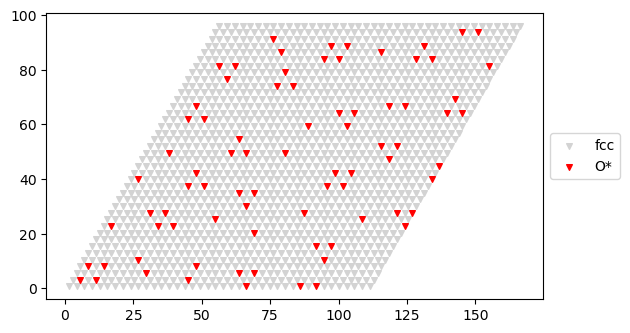

In [78]:
zf.lattice_plot(Path.cwd() /"zacros_run_0050_upto9nn_0070/lattice_input.dat", idx=None, show_axes=True, pause=0.,close=False)

In [55]:
def rdf(confs, coverage, v1, v2, r_max=None, dr=0.1, g_lat=None, lattice_constant=None, ax=None, plot=True):
  """
  Compute 2D radial distribution function g(r) with periodic boundary conditions.

  Parameters
  ----------
  confs : list of (N,2) array_like
      Cartesian coordinates of points.
  v1, v2 : array_like, shape (2,)
      Box vectors spanning the periodic cell.
  r_max : float or None
      Maximum radius to compute g(r). If None use min(box lengths, box diagonal)/2.
  dr : float
      Bin width.

  Returns
  -------
  dist : (M,) array
       Bin midpoints.
  counts/normalization : (M,) array
      Radial distribution function values.
  counts : (M,) array
      Number of unique pairs in each radial bin (unordered pairs).
  edges : (M+1,) array
      Bin edges.
  """
    
  # choose r_max if not provided
  if r_max is None:
      l1 = np.linalg.norm(v1)
      l2 = np.linalg.norm(v2)
      l3 = np.linalg.norm(v1 + v2)
      r_max = min(l1, l2, l3) / 2.0

  cell_matrix = np.vstack([v1, v2]).T
  cell_matrix_inv = np.linalg.inv(cell_matrix)

  nbins = int(np.ceil(r_max / dr))
  edges = np.linspace(0.0, r_max, nbins + 1)
  g = np.zeros(nbins, dtype=int)
  for conf in confs:  
    counts = np.zeros(nbins, dtype=int)
    for i1, r1 in enumerate(conf[:-1]):
      for r2 in conf[i1+1:]:
          r = r2 - r1
          # apply PBC
          frac_r = cell_matrix_inv @ r
          r = cell_matrix @ (frac_r - np.rint(frac_r))
          d = np.linalg.norm(r)
          if (d>0) and (d<=r_max): counts[int(d/dr)] += 1
    # Get 2D lattice ideal gas normalization factor 
    if g_lat is not None: 
      counts_n = np.zeros_like(counts, dtype=float)
      np.divide(counts, g_lat, out=counts_n, where=g_lat!=0)
      g = g + counts_n / len(conf) / coverage  # normalize by coverage
    else:
      g = g + counts / len(conf) / coverage  # normalize by coverage

  dist = 0.5 * (edges[:-1] + edges[1:])

  # Normalization by number of configurations 
  # factor of 2 for unordered pairs
  g = 2*g / len(confs)

  # plotting

  if ax is None:
      fig, ax = plt.subplots()
  if lattice_constant is None:
    ax.set_xlabel(r'$r (\mathrm{\AA})$')
    lattice_constant = 1
  else:
    ax.set_xlabel(r'$r / a_0$')
  ax.set_ylabel(r'g(r)')
  ax.plot(dist/lattice_constant, g, marker='o',color='k')
  #ax.set_ylim(bottom=0)
  ax.grid(True)
  if plot:
      plt.show()
      
  return dist, g #, edges



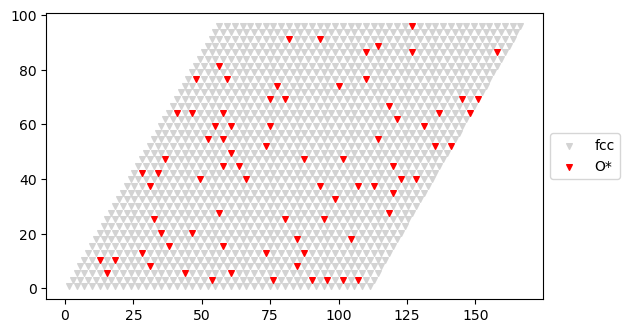

In [78]:
data = Path.cwd() /"zacros_run_0050_upto5nn_0200/lattice_input.dat"
lattice_xy,v1,v2 = get_lattice_xy(data)
ads_coords = zf.get_xy(data)
zf.lattice_plot(data, idx=10)


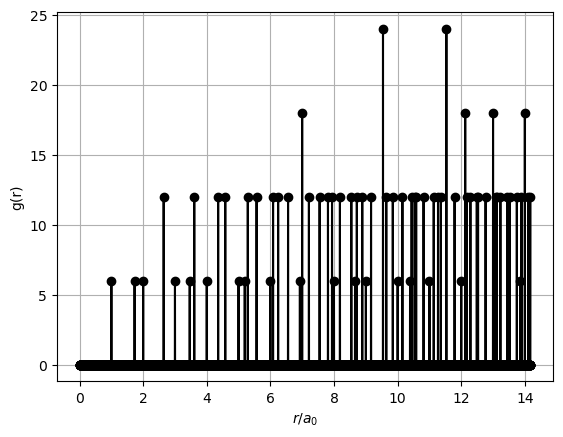

In [64]:
r_lat, g_lat = rdf([lattice_xy],1, v1, v2, lattice_constant=lattice_constant, r_max=40.0, dr=0.01)


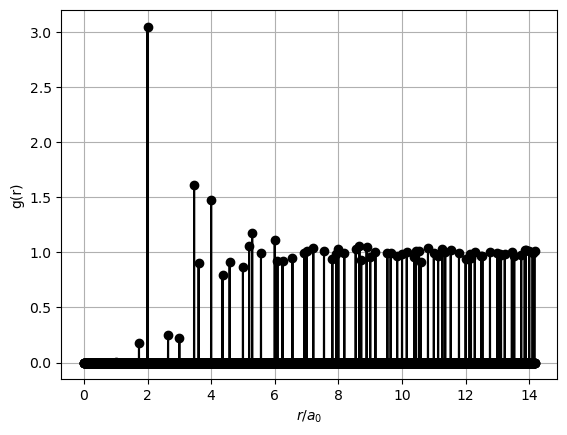

(array([5.0000e-03, 1.5000e-02, 2.5000e-02, ..., 3.9975e+01, 3.9985e+01,
        3.9995e+01], shape=(4000,)),
 array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.01552288], shape=(4000,)))

In [79]:
rdf(ads_coords[49:],0.05, v1, v2, lattice_constant=lattice_constant, r_max=40.0, dr=0.01, g_lat=g_lat)

In [ ]:

plot_rdf(ads_coords[99:], v1, v2, lattice_constant=lattice_constant, r_max=40.0, dr=0.1, normalize=False)

labels, clusters, sizes = zf.cluster_points_periodic(ads_coords[0], v1, v2, cutoff=2.001*lattice_constant)
zf.plot_cluster_size_distribution(sizes)

res = zf.cluster_circularity_periodic(ads_coords[0], v1, v2, cutoff=2.001*lattice_constant)
print("n clusters:", len(res['clusters']))
zf.plot_cluster_size_and_circularity(res['sizes'], res['circularities'])

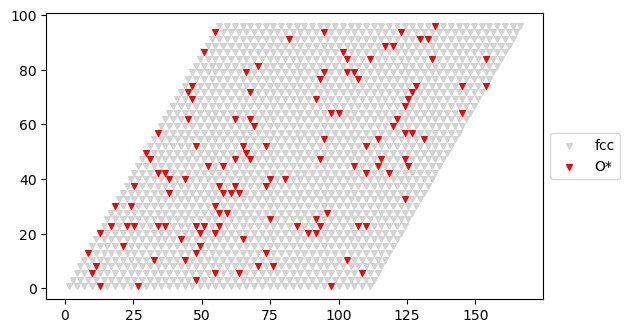

In [43]:
ads_coords,v1,v2 = zf.get_xy(Path.cwd() /"zacros_run_0080_upto0nn_0200/lattice_input.dat")
zf.lattice_plot(Path.cwd() /"zacros_run_0080_upto0nn_0200/lattice_input.dat")

In [45]:
ads_coords[0]

array([12.6951075 , 20.35978815])

In [ ]:

plot_rdf(ads_coords, v1, v2, lattice_constant=lattice_constant, r_max=40.0, dr=0.1)

In [ ]:
n_clusters = []
cluster_counts = []
lat_sizes = [f"{i}x{i}" for i in range(3, 15)]
for lat_size in lat_sizes:

    with open(run_dir / lat_size / 'energlist_output.txt', 'r') as file:
        lines = file.readlines()

    cl_names = lines[0].split()[1:]
    for i, line in enumerate(lines):
        if 'energetics_list_entry' in line: break
        
    n_clusters.append(int(lines[i+1].split()[0]))
    cluster_list = [int(line.split()[0]) for line in lines[i+2: i+2+n_clusters[-1]]]

    cluster_counts.append([cluster_list.count(i) for i in range(1, 11)])


# Extract lattice sizes as numbers (e.g., '3x3' -> 3)
x_vals = [int(size.split('x')[0]) for size in lat_sizes]

for i in range(10):

    plt.figure()
    plt.xlabel('Lattice Size (N)')
    plt.ylabel('# of Clusters / # of adsorbates')
    plt.title(f'# of {cl_names[i]} clusters')
    plt.grid(True)

    y_vals = [cluster_counts[l][i]/nsites**2 for l, nsites in enumerate(x_vals)]
    plt.plot(x_vals, y_vals,'o-')




TypeError: unsupported operand type(s) for /: 'str' and 'str'

In [ ]:
96/16

6.0